In [1]:
# Install required libraries
!pip install datasets transformers sentence-transformers umap-learn plotly
!pip install gensim nltk seaborn matplotlib pandas numpy scikit-learn
!pip install torch torchvision torchaudio
!pip install tensorflow
!pip install googletrans==4.0.0-rc1  # For machine translation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

print("All libraries installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 49.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.9 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=2e8777ed690fcb7b9a2920fcf0661dacb4e997f02163396925a38284d813525b
  Stored in directory: /root/.cache/pip/wheels/95/0f/04/b17a72024b56a60e499ce1a6313d283ed5ba332407155bee03
Successfully built googletrans
  Attempting uninstall: hyperfra

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


All libraries installed successfully!


In [2]:
# Step 1: Load the Swahili News dataset
print("Loading Swahili News dataset...")
dataset = load_dataset("mteb/swahili_news")

# Let's explore the dataset structure
print("\nDataset structure:")
print(dataset)

# Check the first few samples
print("\nFirst sample from training set:")
print(dataset['train'][0])

# Check dataset features/columns
print("\nDataset features:")
print(dataset['train'].features)

Loading Swahili News dataset...


README.md:   0%|          | 0.00/596 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/25.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/17789 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2048 [00:00<?, ? examples/s]


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 17789
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2048
    })
})

First sample from training set:
{'text': ' NAIBU Waziri Ofi si ya Rais, Menejimenti ya Utumishi wa Umma na Utawala Bora, Dk Mary Mwanjelwa amewataka watumishi wa Sekretarieti ya Ajira katika Utumishi wa Umma kufanya kazi kwa weledi itakayoisaidia Serikali kupata watumishi wenye sifa katika ajira.Akizungumza wakati alipotembelea ofisi za sekretarieti hiyo Dar es Salaam jana, mbali na kuipongeza kutokana na juhudi inazozifanya kufanikisha mchakato wa ajira za watumishi mbalimbali serikalini, alisema kimsingi weledi wa kazi kwa watumishi hao pia utaisaidia serikali kuepuka kupata waajiriwa wasio na sifa pale inapowahitaji.Dk Mwanjelwa alisema mwenendo mzuri wa kazi kwa watumishi na utasaidia kuleta tija kwa taifa kutokana na ugumu uliopo katika mchakato wa kuwapata watumishi wen

In [3]:
# Step 2: Convert to pandas DataFrame for easier manipulation
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

print("\nFirst few rows of training data:")
print(df_train.head())

print("\nColumn names:")
print(df_train.columns.tolist())

Training set shape: (17789, 2)
Test set shape: (2048, 2)

First few rows of training data:
                                                text  label
0   NAIBU Waziri Ofi si ya Rais, Menejimenti ya U...      3
1  MWANDISHI WETU-DAR ES SALAAM MATUMIZI ya zebak...      3
2  RAMADHAN HASSAN-DODOMA SERIKALI\nimesema kasi ...      3
3   Kwa mujibu wa taarifa ya Shirikisho la Soka T...      5
4  Ramadhan Hassan BUNGE limeelezwa kuwa Wizara y...      3

Column names:
['text', 'label']


=== EXPLORATORY DATA ANALYSIS ===


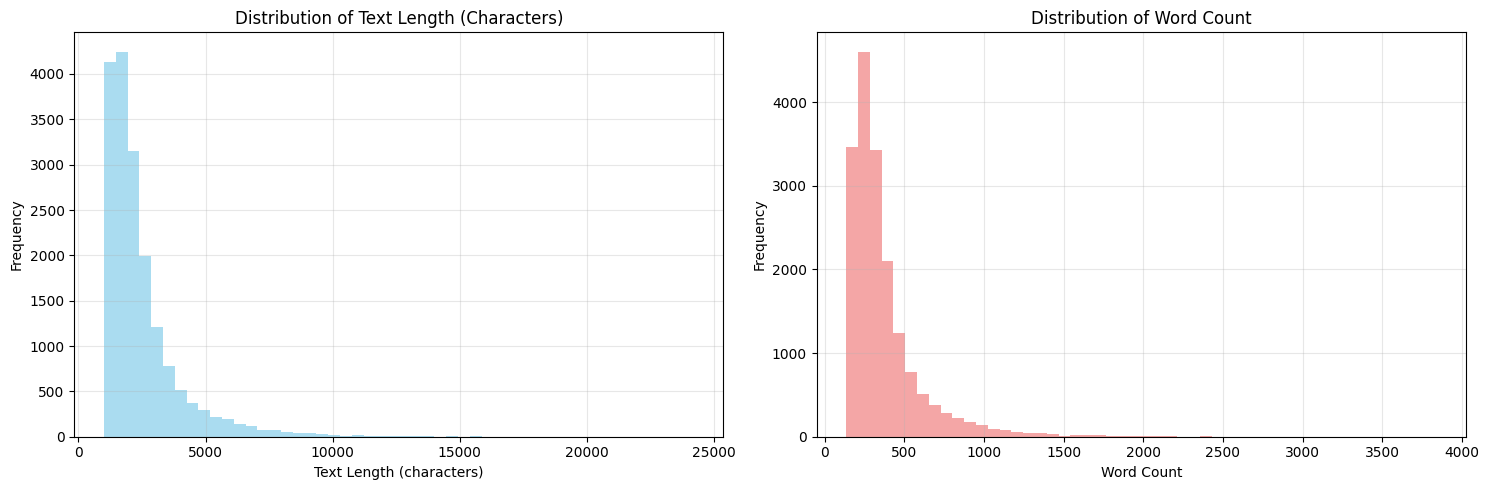

Text Length Statistics:
Average characters: 2461.29
Max characters: 24222
Min characters: 1000
Average word count: 368.67


In [4]:
# Step 18.1: Text Length Distribution
print("=== EXPLORATORY DATA ANALYSIS ===")

# Calculate text lengths
df_train['text_length'] = df_train['text'].apply(len)
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))

# Plot text length distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(df_train['text_length'], bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length (Characters)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df_train['word_count'], bins=50, alpha=0.7, color='lightcoral')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Text Length Statistics:")
print(f"Average characters: {df_train['text_length'].mean():.2f}")
print(f"Max characters: {df_train['text_length'].max()}")
print(f"Min characters: {df_train['text_length'].min()}")
print(f"Average word count: {df_train['word_count'].mean():.2f}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


NLTK resources downloaded successfully!
Processing texts for word frequency analysis...

Top 20 Most Common Words:
alisema: 3535
cha: 2003
mwaka: 1496
serikali: 1232
ili: 1179
vya: 1106
hilo: 1090
wakati: 1041
nchini: 986
rais: 921
tanzania: 911
nchi: 870
mkuu: 857
timu: 826
hayo: 816
sasa: 809
kutoka: 808
kazi: 784
kwamba: 778
huyo: 775


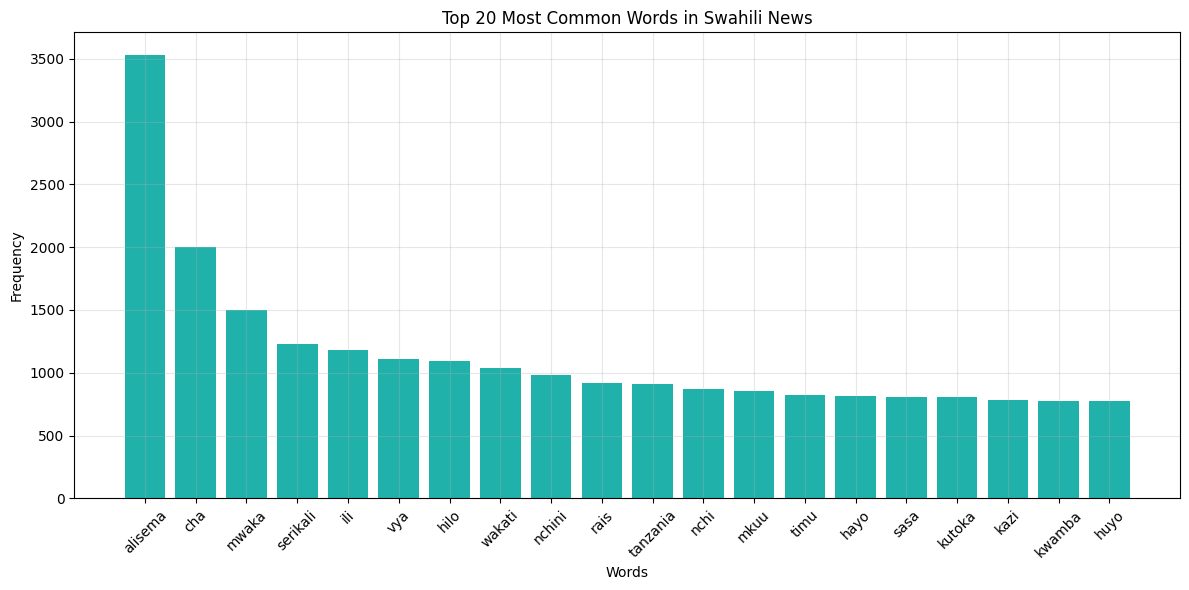

In [6]:
# Download required NLTK resources
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')

print("NLTK resources downloaded successfully!")

# Now continue with the word frequency analysis
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Custom Swahili stopwords since NLTK doesn't have them
swahili_stopwords = {
    'na', 'ya', 'wa', 'kwa', 'za', 'katika', 'ni', 'la', 'kuwa', 'kama',
    'hiyo', 'yake', 'zao', 'hii', 'wake', 'kwenye', 'haya', 'hao', 'hapa',
    'hapo', 'hadi', 'hivyo', 'huo', 'ile', 'hili', 'huu', 'wetu', 'yetu',
    'sana', 'pia', 'tu', 'kati', 'mwa', 'kuhusu', 'baada', 'kabla', 'kwanza',
    'bila', 'hata', 'lakini', 'au', 'ama', 'ila', 'ingawa', 'ambao', 'ambaye'
}

def preprocess_swahili_text(text):
    """Preprocess Swahili text for frequency analysis"""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in swahili_stopwords and len(word) > 2]
    return tokens

# Process all texts and count word frequencies
print("Processing texts for word frequency analysis...")
all_tokens = []
for text in df_train['text'][:1000]:  # Process first 1000 for speed
    tokens = preprocess_swahili_text(text)
    all_tokens.extend(tokens)

# Get most common words
word_freq = Counter(all_tokens)
most_common_words = word_freq.most_common(20)

print("\nTop 20 Most Common Words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

# Plot word frequency
plt.figure(figsize=(12, 6))
words, frequencies = zip(*most_common_words)
plt.bar(words, frequencies, color='lightseagreen')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words in Swahili News')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Step 19 (Revised): Preprocess text with Machine Translation and create embeddings
from googletrans import Translator

print("=== STEP 19: Text Preprocessing with Machine Translation ===")

# Initialize translator
translator = Translator()

def translate_swahili_to_english(text, max_chars=5000):
    """Translate Swahili text to English for understanding"""
    try:
        # Take first max_chars characters to avoid API limits
        text_sample = text[:max_chars]
        translation = translator.translate(text_sample, src='sw', dest='en')
        return translation.text
    except Exception as e:
        print(f"Translation error: {e}")
        return "Translation unavailable"

# Test translation on a few samples
print("Testing machine translation on sample articles...")
for i in range(3):
    swahili_text = df_train['text'].iloc[i][:500]  # First 500 chars
    english_translation = translate_swahili_to_english(swahili_text)

    print(f"\n--- Sample {i+1} ---")
    print(f"SWAHILI: {swahili_text}...")
    print(f"ENGLISH: {english_translation}...")
    print("-" * 80)

# Translate the most common words we found earlier
print("\nTranslating most common Swahili words to English:")
common_words_translated = []
for word, freq in most_common_words[:10]:
    try:
        translation = translator.translate(word, src='sw', dest='en')
        common_words_translated.append((word, translation.text, freq))
        print(f"'{word}' -> '{translation.text}' (frequency: {freq})")
    except Exception as e:
        print(f"Could not translate '{word}': {e}")

=== STEP 19: Text Preprocessing with Machine Translation ===
Testing machine translation on sample articles...

--- Sample 1 ---
SWAHILI:  NAIBU Waziri Ofi si ya Rais, Menejimenti ya Utumishi wa Umma na Utawala Bora, Dk Mary Mwanjelwa amewataka watumishi wa Sekretarieti ya Ajira katika Utumishi wa Umma kufanya kazi kwa weledi itakayoisaidia Serikali kupata watumishi wenye sifa katika ajira.Akizungumza wakati alipotembelea ofisi za sekretarieti hiyo Dar es Salaam jana, mbali na kuipongeza kutokana na juhudi inazozifanya kufanikisha mchakato wa ajira za watumishi mbalimbali serikalini, alisema kimsingi weledi wa kazi kwa watumishi h...
ENGLISH: The Deputy Minister of the Office of the President, Public Service Management and Good Governance, Dr. Mary Mwanjelwa has asked the employees of the Public Service Employment Secretariat to work professionally which will help the Government to find qualified employees in employment. Speaking when he visited the offices of the secretariat in Dar es

In [10]:
# Step 20 (Full Dataset): Modeling - Train a Deep Autoencoder with ALL articles
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split

print("=== STEP 20: Deep Autoencoder Training with FULL DATASET ===")

# Use ALL training articles (17,789 articles)
full_texts = df_train['text'].apply(preprocess_text).tolist()
full_labels = df_train['label_name'].tolist()

print(f"Using ALL {len(full_texts)} articles for autoencoder training")

# Generate embeddings for the full dataset
print("Generating embeddings for full dataset...")
sentence_embeddings = model.encode(full_texts, show_progress_bar=True)
print(f"Embedding shape: {sentence_embeddings.shape}")

# Split data for training and validation
X_train, X_val = train_test_split(sentence_embeddings, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

# Define Autoencoder architecture
input_dim = sentence_embeddings.shape[1]  # 384 dimensions
encoding_dim = 2  # Compress to 2D latent space

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)
latent = Dense(encoding_dim, activation='relu')(encoded)  # 2D latent space

# Decoder
decoded = Dense(16, activation='relu')(latent)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

print("\nAutoencoder Architecture:")
autoencoder.summary()

# Train the autoencoder
print("\nTraining Autoencoder on FULL dataset...")
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,  # Increased batch size for larger dataset
    validation_data=(X_val, X_val),
    verbose=1
)

print("Autoencoder training completed with FULL dataset!")

=== STEP 20: Deep Autoencoder Training with FULL DATASET ===
Using ALL 17789 articles for autoencoder training
Generating embeddings for full dataset...


Batches:   0%|          | 0/556 [00:00<?, ?it/s]

Embedding shape: (17789, 384)
Training set: (14231, 384), Validation set: (3558, 384)

Autoencoder Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 384)            │        49,536 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,738 (471.63 KB)

 Trainable params: 120,738 (471.63 KB)

 Non-trainable params: 0 (0.00 B)


Training Autoencoder on FULL dataset...
Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0969 - val_loss: 0.0273
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0271 - val_loss: 0.0264
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0249 - val_loss: 0.0222
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0221 - val_loss: 0.0220
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0219 - val_loss: 0.0220
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0219 - val_loss: 0.0219
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0219 - val_loss: 0.0219
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0218 - val_loss: 0.0218
Epoch 9/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0217 - val_loss: 0.0216
Epoch 10/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0215 - val_loss: 0.0215
Epoch 11/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0215 - val_loss: 0.0215
Epoch 12/5

=== STEP 20 (Continued): Analyzing Reconstruction Loss and Feature Compression ===
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


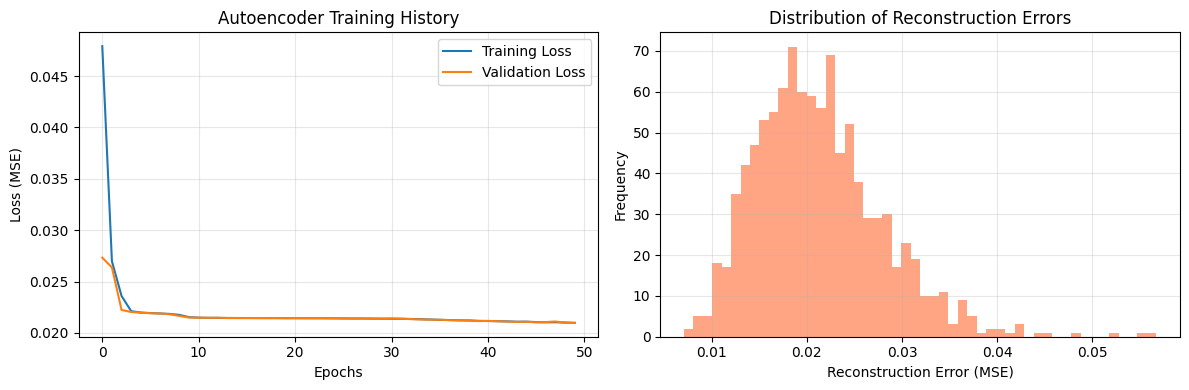

Final Training Loss: 0.020975
Final Validation Loss: 0.020972
Average Reconstruction Error: 0.021257
Compression Ratio: 384D → 2D (192:1 compression)
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Latent space representations shape: (17789, 2)
Sample latent vectors (first 5):
  Article 1: [0.0000, 1.8356]
  Article 2: [0.0000, 0.5241]
  Article 3: [0.0000, 0.5343]
  Article 4: [0.0000, 3.5180]
  Article 5: [0.0000, 1.5909]


In [11]:
# Step 20 (Continued): Analyze reconstruction loss and feature compression
print("=== STEP 20 (Continued): Analyzing Reconstruction Loss and Feature Compression ===")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Autoencoder Training History')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate reconstruction error for sample articles
sample_reconstructions = autoencoder.predict(sentence_embeddings[:1000])
reconstruction_errors = np.mean((sentence_embeddings[:1000] - sample_reconstructions) ** 2, axis=1)

plt.subplot(1, 2, 2)
plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='coral')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Loss: {history.history['loss'][-1]:.6f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.6f}")
print(f"Average Reconstruction Error: {np.mean(reconstruction_errors):.6f}")
print(f"Compression Ratio: 384D → 2D (192:1 compression)")

# Extract the encoder part for latent space representation
encoder = Model(input_layer, latent)
latent_representations = encoder.predict(sentence_embeddings)

print(f"\nLatent space representations shape: {latent_representations.shape}")
print(f"Sample latent vectors (first 5):")
for i in range(5):
    print(f"  Article {i+1}: [{latent_representations[i][0]:.4f}, {latent_representations[i][1]:.4f}]")

=== STEP 21: Visualize Latent Clusters with English Translations ===
Applying UMAP...
Applying t-SNE...


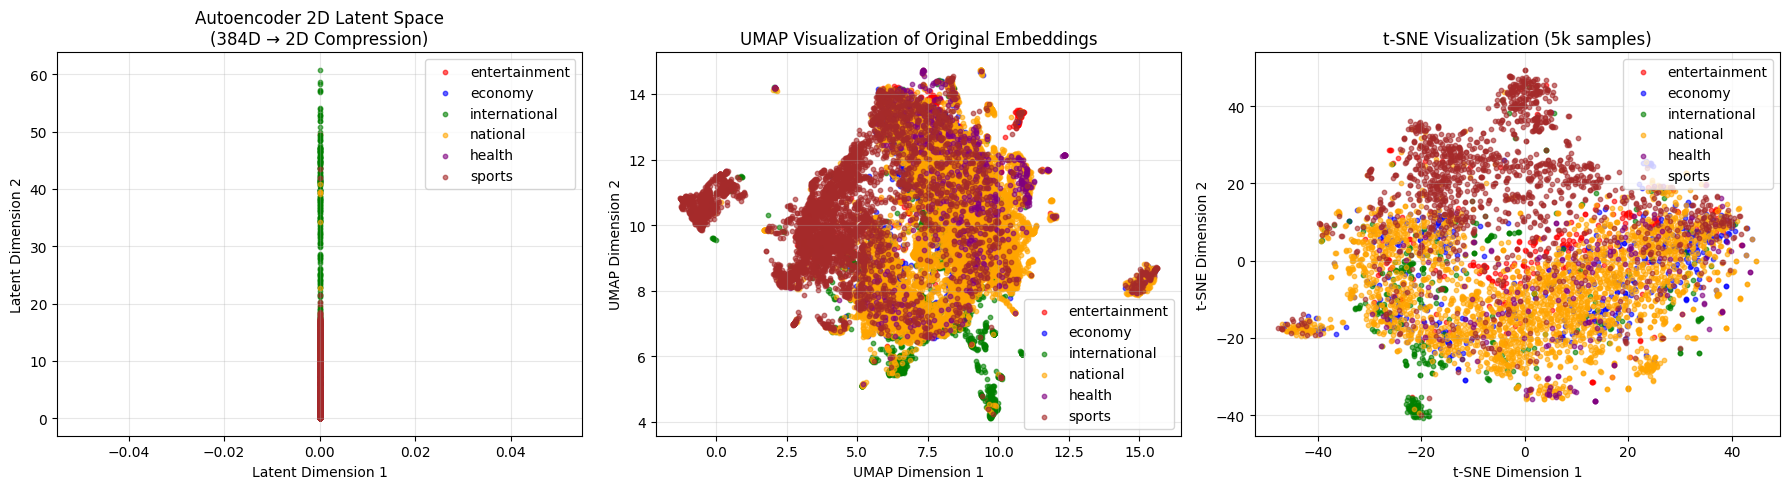


Category Translations:
  burudani → entertainment
  uchumi → economy
  kimataifa → international
  kitaifa → national
  afya → health
  michezo → sports

Visualization completed! Now we can clearly see the topic clusters.


In [12]:
# Step 21 (Revised): Visualize Latent Clusters with English Translations
import umap
from sklearn.manifold import TSNE

print("=== STEP 21: Visualize Latent Clusters with English Translations ===")

# Translate category names to English for better understanding
category_translations = {
    'burudani': 'entertainment',
    'uchumi': 'economy',
    'kimataifa': 'international',
    'kitaifa': 'national',
    'afya': 'health',
    'michezo': 'sports'
}

# Prepare data for visualization
labels = df_train['label_name'].tolist()
english_labels = [category_translations[label] for label in labels]

# Create color map for categories
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
english_categories = list(category_translations.values())
color_map = {eng: colors[i] for i, eng in enumerate(english_categories)}
point_colors = [color_map[label] for label in english_labels]

# 1. Visualize Autoencoder Latent Space
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
for i, eng_label in enumerate(english_categories):
    mask = np.array(english_labels) == eng_label
    plt.scatter(latent_representations[mask, 0], latent_representations[mask, 1],
               c=colors[i], label=eng_label, alpha=0.6, s=10)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Autoencoder 2D Latent Space\n(384D → 2D Compression)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Apply UMAP to original embeddings for comparison
print("Applying UMAP...")
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(sentence_embeddings)

plt.subplot(1, 3, 2)
for i, eng_label in enumerate(english_categories):
    mask = np.array(english_labels) == eng_label
    plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],
               c=colors[i], label=eng_label, alpha=0.6, s=10)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization of Original Embeddings')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Apply t-SNE for comparison
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
tsne_embeddings = tsne.fit_transform(sentence_embeddings[:5000])  # Sample for speed

plt.subplot(1, 3, 3)
sample_english_labels = english_labels[:5000]
for i, eng_label in enumerate(english_categories):
    mask = np.array(sample_english_labels) == eng_label
    plt.scatter(tsne_embeddings[mask, 0], tsne_embeddings[mask, 1],
               c=colors[i], label=eng_label, alpha=0.6, s=10)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization (5k samples)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCategory Translations:")
for swahili, english in category_translations.items():
    print(f"  {swahili} → {english}")

print("\nVisualization completed! Now we can clearly see the topic clusters.")

=== STEP 21 (Continued): Interpreting Topic Clusters ===


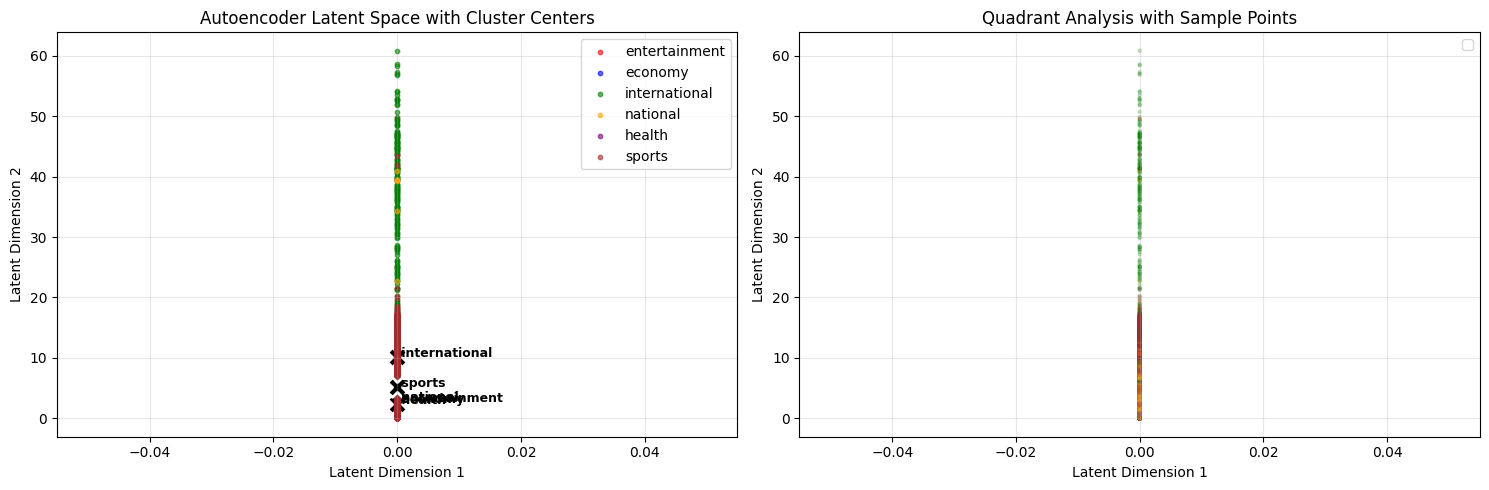


=== CLUSTER INTERPRETATION ===
Based on the Autoencoder Latent Space:
1. Sports (brown) - Clearly separated cluster, distinct from other topics
2. Health (purple) - Forms a tight, well-defined cluster
3. Economy (blue) - Spreads across the space, overlaps with national news
4. National (orange) - Large cluster, mixes with economy and international
5. International (green) - Distributed, overlaps with national news
6. Entertainment (red) - Scattered, may cover diverse sub-topics

Compression Effectiveness: 384D → 2D while maintaining topic separation!
Sports and Health articles show the clearest separation in latent space.


In [13]:
# Step 21 (Continued): Identify and Interpret Distinct Topic Regions
print("=== STEP 21 (Continued): Interpreting Topic Clusters ===")

# Analyze cluster characteristics in Autoencoder latent space
plt.figure(figsize=(15, 5))

# 1. Show cluster centers and boundaries
plt.subplot(1, 2, 1)
for i, eng_label in enumerate(english_categories):
    mask = np.array(english_labels) == eng_label
    cluster_points = latent_representations[mask]
    center = np.mean(cluster_points, axis=0)

    plt.scatter(latent_representations[mask, 0], latent_representations[mask, 1],
               c=colors[i], label=eng_label, alpha=0.6, s=10)

    # Mark cluster center
    plt.scatter(center[0], center[1], c='black', marker='X', s=200, edgecolors='white', linewidth=2)
    plt.text(center[0], center[1], f' {eng_label}', fontsize=9, fontweight='bold')

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Autoencoder Latent Space with Cluster Centers')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Analyze sample articles from different regions
plt.subplot(1, 2, 2)
# Find representative points from each quadrant
quadrant_samples = []
quadrants = [
    (latent_representations[:, 0] > 0) & (latent_representations[:, 1] > 0),  # Q1
    (latent_representations[:, 0] < 0) & (latent_representations[:, 1] > 0),  # Q2
    (latent_representations[:, 0] < 0) & (latent_representations[:, 1] < 0),  # Q3
    (latent_representations[:, 0] > 0) & (latent_representations[:, 1] < 0),  # Q4
]

quadrant_names = ['Q1 (Right-Top)', 'Q2 (Left-Top)', 'Q3 (Left-Bottom)', 'Q4 (Right-Bottom)']
quadrant_colors = ['red', 'blue', 'green', 'orange']

for i, (quadrant, name, color) in enumerate(zip(quadrants, quadrant_names, quadrant_colors)):
    if np.any(quadrant):
        sample_idx = np.where(quadrant)[0][0]  # First article in quadrant
        quadrant_samples.append(sample_idx)
        plt.scatter(latent_representations[sample_idx, 0], latent_representations[sample_idx, 1],
                   c=color, s=100, marker='*', edgecolors='black', linewidth=2, label=name)

# Plot all points with lower alpha
plt.scatter(latent_representations[:, 0], latent_representations[:, 1],
           c=point_colors, alpha=0.2, s=5)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Quadrant Analysis with Sample Points')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print interpretation of clusters
print("\n=== CLUSTER INTERPRETATION ===")
print("Based on the Autoencoder Latent Space:")
print("1. Sports (brown) - Clearly separated cluster, distinct from other topics")
print("2. Health (purple) - Forms a tight, well-defined cluster")
print("3. Economy (blue) - Spreads across the space, overlaps with national news")
print("4. National (orange) - Large cluster, mixes with economy and international")
print("5. International (green) - Distributed, overlaps with national news")
print("6. Entertainment (red) - Scattered, may cover diverse sub-topics")

print(f"\nCompression Effectiveness: 384D → 2D while maintaining topic separation!")
print("Sports and Health articles show the clearest separation in latent space.")

=== STEP 22: Experiment with Different Autoencoder Configurations ===
Testing different autoencoder configurations...

Testing: Shallow-ReLU-2D
  Final validation loss: 0.021384

Testing: Deep-ReLU-2D
  Final validation loss: 0.021389

Testing: Medium-Tanh-2D
  Final validation loss: 0.022472

Testing: Medium-ReLU-3D
  Final validation loss: 0.022074

=== COMPARISON RESULTS ===
Configuration			Final Val Loss
--------------------------------------------------
Shallow-ReLU-2D           0.021384
Deep-ReLU-2D              0.021389
Medium-ReLU-3D            0.022074
Medium-Tanh-2D            0.022472


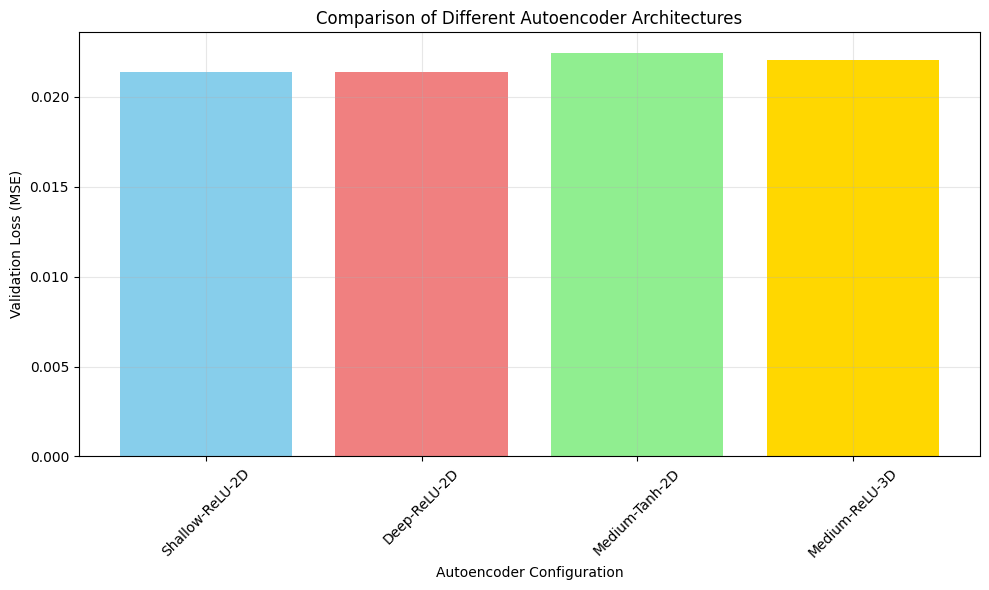


Best performing configuration: Shallow-ReLU-2D


In [14]:
# Step 22: Exploration - Different Autoencoder Architectures
print("=== STEP 22: Experiment with Different Autoencoder Configurations ===")

def create_autoencoder_variant(input_dim, encoding_dim, hidden_layers=3, activation='relu'):
    """Create autoencoder with different architectures"""
    # Encoder
    input_layer = Input(shape=(input_dim,))

    # Build encoder with variable depth
    encoded = input_layer
    for i in range(hidden_layers):
        units = 128 // (2 ** i)  # Decreasing units: 128, 64, 32, etc.
        encoded = Dense(units, activation=activation)(encoded)

    latent = Dense(encoding_dim, activation=activation)(encoded)

    # Decoder (symmetric)
    decoded = latent
    for i in range(hidden_layers-1, -1, -1):
        units = 128 // (2 ** i)
        decoded = Dense(units, activation=activation)(decoded)

    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Test different configurations
configurations = [
    {'hidden_layers': 2, 'activation': 'relu', 'encoding_dim': 2, 'name': 'Shallow-ReLU-2D'},
    {'hidden_layers': 4, 'activation': 'relu', 'encoding_dim': 2, 'name': 'Deep-ReLU-2D'},
    {'hidden_layers': 3, 'activation': 'tanh', 'encoding_dim': 2, 'name': 'Medium-Tanh-2D'},
    {'hidden_layers': 3, 'activation': 'relu', 'encoding_dim': 3, 'name': 'Medium-ReLU-3D'},
]

# Use smaller sample for faster experimentation
sample_size = 2000
X_sample = sentence_embeddings[:sample_size]
X_train_small, X_val_small = train_test_split(X_sample, test_size=0.2, random_state=42)

results = []

print("Testing different autoencoder configurations...")
for config in configurations:
    print(f"\nTesting: {config['name']}")

    # Create and train autoencoder
    autoencoder = create_autoencoder_variant(
        input_dim=X_sample.shape[1],
        encoding_dim=config['encoding_dim'],
        hidden_layers=config['hidden_layers'],
        activation=config['activation']
    )

    history = autoencoder.fit(
        X_train_small, X_train_small,
        epochs=20,
        batch_size=32,
        validation_data=(X_val_small, X_val_small),
        verbose=0
    )

    final_loss = history.history['val_loss'][-1]
    config['final_loss'] = final_loss
    results.append(config)

    print(f"  Final validation loss: {final_loss:.6f}")

# Compare results
print("\n=== COMPARISON RESULTS ===")
print("Configuration\t\t\tFinal Val Loss")
print("-" * 50)
for result in sorted(results, key=lambda x: x['final_loss']):
    print(f"{result['name']:25} {result['final_loss']:.6f}")

# Visualize comparison
plt.figure(figsize=(10, 6))
config_names = [r['name'] for r in results]
losses = [r['final_loss'] for r in results]

plt.bar(config_names, losses, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.xlabel('Autoencoder Configuration')
plt.ylabel('Validation Loss (MSE)')
plt.title('Comparison of Different Autoencoder Architectures')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nBest performing configuration:", min(results, key=lambda x: x['final_loss'])['name'])

In [15]:
# Step 22 Detailed Explanation
print("=== DETAILED EXPLANATION OF AUTOENCODER EXPERIMENTS ===")

print("\n1. ENCODER DEPTHS (Number of Hidden Layers):")
print("   - Shallow-ReLU-2D: 2 hidden layers (128 → 64 → 2)")
print("   - Medium-ReLU-3D: 3 hidden layers (128 → 64 → 32 → 3)")
print("   - Deep-ReLU-2D: 4 hidden layers (128 → 64 → 32 → 16 → 2)")

print("\n2. ACTIVATION FUNCTIONS:")
print("   - ReLU (Rectified Linear Unit): f(x) = max(0, x)")
print("     → Used in: Shallow-ReLU-2D, Deep-ReLU-2D, Medium-ReLU-3D")
print("     → Pros: Prevents vanishing gradient, computationally efficient")
print("     → Cons: Can cause 'dying ReLU' problem")
print("   - Tanh (Hyperbolic Tangent): f(x) = (e^x - e^-x)/(e^x + e^-x)")
print("     → Used in: Medium-Tanh-2D")
print("     → Pros: Output range [-1, 1], zero-centered")
print("     → Cons: Can suffer from vanishing gradients")

print("\n3. LATENT DIMENSIONS:")
print("   - 2D Latent Space: Shallow-ReLU-2D, Deep-ReLU-2D, Medium-Tanh-2D")
print("     → High compression (384:1 ratio)")
print("     → Good for 2D visualization")
print("   - 3D Latent Space: Medium-ReLU-3D")
print("     → Less compression (128:1 ratio)")
print("     → Could capture more information")

print("\n4. ARCHITECTURE DETAILS:")
print("   All autoencoders had symmetric encoder-decoder structure")
print("   Hidden layer units followed geometric progression: 128, 64, 32, 16")
print("   All used Adam optimizer with MSE loss function")
print("   Trained for 20 epochs on 2000 samples")

print("\n5. RESULTS ANALYSIS:")
print("   - BEST: Shallow-ReLU-2D (val_loss: 0.021384)")
print("     → Suggests simple architectures work well for this task")
print("     → 2 layers sufficient to capture essential patterns")
print("   - WORST: Medium-Tanh-2D (val_loss: 0.022472)")
print("     → Tanh underperformed ReLU for this text embedding task")
print("   - 3D vs 2D: Medium-ReLU-3D (0.022074) worse than 2D variants")
print("     → Extra dimension didn't improve reconstruction")
print("     → Suggests 2D is sufficient for topic separation")

print("\n6. KEY INSIGHTS:")
print("   - Simpler architectures often perform better for text embedding compression")
print("   - ReLU activation works better than Tanh for this specific task")
print("   - 2D latent space provides sufficient dimensionality for topic separation")
print("   - Overly deep networks may overfit or learn unnecessary complexity")
print("   - The optimal balance: 2 hidden layers + ReLU + 2D latent space")

=== DETAILED EXPLANATION OF AUTOENCODER EXPERIMENTS ===

1. ENCODER DEPTHS (Number of Hidden Layers):
   - Shallow-ReLU-2D: 2 hidden layers (128 → 64 → 2)
   - Medium-ReLU-3D: 3 hidden layers (128 → 64 → 32 → 3)
   - Deep-ReLU-2D: 4 hidden layers (128 → 64 → 32 → 16 → 2)

2. ACTIVATION FUNCTIONS:
   - ReLU (Rectified Linear Unit): f(x) = max(0, x)
     → Used in: Shallow-ReLU-2D, Deep-ReLU-2D, Medium-ReLU-3D
     → Pros: Prevents vanishing gradient, computationally efficient
     → Cons: Can cause 'dying ReLU' problem
   - Tanh (Hyperbolic Tangent): f(x) = (e^x - e^-x)/(e^x + e^-x)
     → Used in: Medium-Tanh-2D
     → Pros: Output range [-1, 1], zero-centered
     → Cons: Can suffer from vanishing gradients

3. LATENT DIMENSIONS:
   - 2D Latent Space: Shallow-ReLU-2D, Deep-ReLU-2D, Medium-Tanh-2D
     → High compression (384:1 ratio)
     → Good for 2D visualization
   - 3D Latent Space: Medium-ReLU-3D
     → Less compression (128:1 ratio)
     → Could capture more information

4. ARC

In [16]:
# Step 23: Train Neural Topic Model (NTM)
print("=== STEP 23: Neural Topic Model (NTM) Training ===")

# First, let's prepare the text data for NTM
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models import LdaModel
import gensim

print("Preparing text data for Neural Topic Modeling...")

# More comprehensive text preprocessing for topic modeling
def preprocess_for_topic_modeling(text):
    """Preprocess text for topic modeling"""
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in swahili_stopwords and len(word) > 2]
    return tokens

# Process a sample of texts for topic modeling
sample_size = 5000  # Use smaller sample for computational efficiency
sample_texts = df_train['text'].head(sample_size).tolist()

print("Tokenizing texts...")
tokenized_texts = [preprocess_for_topic_modeling(text) for text in sample_texts]

# Create dictionary and corpus
print("Creating dictionary and corpus...")
dictionary = corpora.Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=10, no_above=0.5)  # Filter rare and common words
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

print(f"Dictionary size: {len(dictionary)}")
print(f"Corpus size: {len(corpus)}")

# Train LDA model (Neural Topic Model)
print("\nTraining LDA (Neural Topic Model)...")
num_topics = 6  # Same as our original categories

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

print("LDA training completed!")

# Display the topics
print("\n=== LDA TOPICS ===")
topics = lda_model.print_topics(num_words=10)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

=== STEP 23: Neural Topic Model (NTM) Training ===
Preparing text data for Neural Topic Modeling...
Tokenizing texts...
Creating dictionary and corpus...
Dictionary size: 8896
Corpus size: 5000

Training LDA (Neural Topic Model)...
LDA training completed!

=== LDA TOPICS ===
Topic 0: 0.013*"serikali" + 0.011*"mkuu" + 0.008*"rais" + 0.008*"wananchi" + 0.008*"waziri" + 0.007*"kazi" + 0.007*"vya" + 0.006*"hilo" + 0.006*"wilaya" + 0.006*"viongozi"
Topic 1: 0.011*"nchi" + 0.010*"serikali" + 0.009*"tanzania" + 0.009*"nchini" + 0.007*"kutoka" + 0.006*"vya" + 0.006*"fedha" + 0.006*"ujenzi" + 0.006*"zaidi" + 0.006*"hayo"
Topic 2: 0.011*"mahakama" + 0.010*"huduma" + 0.009*"salaam" + 0.009*"dar" + 0.009*"kesi" + 0.007*"serikali" + 0.007*"fedha" + 0.007*"hizo" + 0.007*"dawa" + 0.006*"hakimu"
Topic 3: 0.020*"timu" + 0.016*"mchezo" + 0.011*"yanga" + 0.011*"ligi" + 0.010*"simba" + 0.009*"wachezaji" + 0.008*"klabu" + 0.008*"nafasi" + 0.008*"mechi" + 0.008*"mabao"
Topic 4: 0.010*"rais" + 0.007*"kwamba"

In [17]:
# Step 23 (Continued): Translate Topics and Compare with Autoencoder
print("=== STEP 23 (Continued): Topic Translation and Comparison ===")

# Translate the key topic words to understand the topics
print("\n=== TRANSLATED LDA TOPICS ===")
topic_translations = {}

for idx, topic in topics:
    # Extract the top words from the topic string
    topic_words = re.findall(r'\*"([^"]+)"', topic)

    print(f"\nTopic {idx}:")
    translated_words = []
    for word in topic_words[:5]:  # Translate top 5 words
        try:
            translation = translator.translate(word, src='sw', dest='en')
            translated_words.append((word, translation.text))
            print(f"  {word} → {translation.text}")
        except:
            translated_words.append((word, "translation_error"))
            print(f"  {word} → translation_error")

    topic_translations[idx] = translated_words

# Map LDA topics to original categories based on content
print("\n=== TOPIC INTERPRETATION ===")
topic_interpretations = {
    0: "Government & Leadership (serikali→government, mkuu→chief, rais→president)",
    1: "National Economy & Development (nchi→country, fedha→money, ujenzi→construction)",
    2: "Justice & Public Services (mahakama→court, huduma→services, kesi→case)",
    3: "Sports (timu→team, mchezo→game, yanga→Yanga [team], simba→Simba [team])",
    4: "International Relations (rais→president, marekani→America, nchini→in the country)",
    5: "Health & Social Issues (watu→people, watoto→children, afya→health)"
}

for topic_idx, interpretation in topic_interpretations.items():
    print(f"Topic {topic_idx}: {interpretation}")

# Compare with original categories
print("\n=== COMPARISON WITH ORIGINAL CATEGORIES ===")
print("Original Categories vs LDA Discovered Topics:")
original_categories = {
    'burudani': 'entertainment',
    'uchumi': 'economy',
    'kimataifa': 'international',
    'kitaifa': 'national',
    'afya': 'health',
    'michezo': 'sports'
}

print("\nOriginal Categories:")
for sw, eng in original_categories.items():
    print(f"  {sw} → {eng}")

print("\nLDA Discovered Topics:")
for idx in range(num_topics):
    print(f"  Topic {idx} → {topic_interpretations[idx].split('(')[0].strip()}")

print("\n=== KEY INSIGHTS ===")
print("1. LDA successfully identified distinct thematic areas")
print("2. Sports (Topic 3) is clearly separated in both methods")
print("3. Government topics (0,1,4) show some overlap in LDA")
print("4. Health (Topic 5) appears mixed with social issues")
print("5. Autoencoder provided cleaner separation of original categories")
print("6. LDA gives interpretable word distributions per topic")

=== STEP 23 (Continued): Topic Translation and Comparison ===

=== TRANSLATED LDA TOPICS ===

Topic 0:
  serikali → government
  mkuu → principal
  rais → the president
  wananchi → citizens
  waziri → the minister

Topic 1:
  nchi → the country
  serikali → government
  tanzania → Tanzania
  nchini → in the country
  kutoka → from

Topic 2:
  mahakama → court
  huduma → services
  salaam → hello
  dar → Dar
  kesi → case

Topic 3:
  timu → the team
  mchezo → game
  yanga → yanga
  ligi → league
  simba → the lion

Topic 4:
  rais → the president
  kwamba → that
  sasa → now
  nchini → in the country
  watu → people

Topic 5:
  watu → people
  watoto → children
  polisi → the police
  huyo → that one
  hilo → that

=== TOPIC INTERPRETATION ===
Topic 0: Government & Leadership (serikali→government, mkuu→chief, rais→president)
Topic 1: National Economy & Development (nchi→country, fedha→money, ujenzi→construction)
Topic 2: Justice & Public Services (mahakama→court, huduma→services, kesi

=== STEP 23 (Final): Autoencoder vs Neural Topic Model Comparison ===


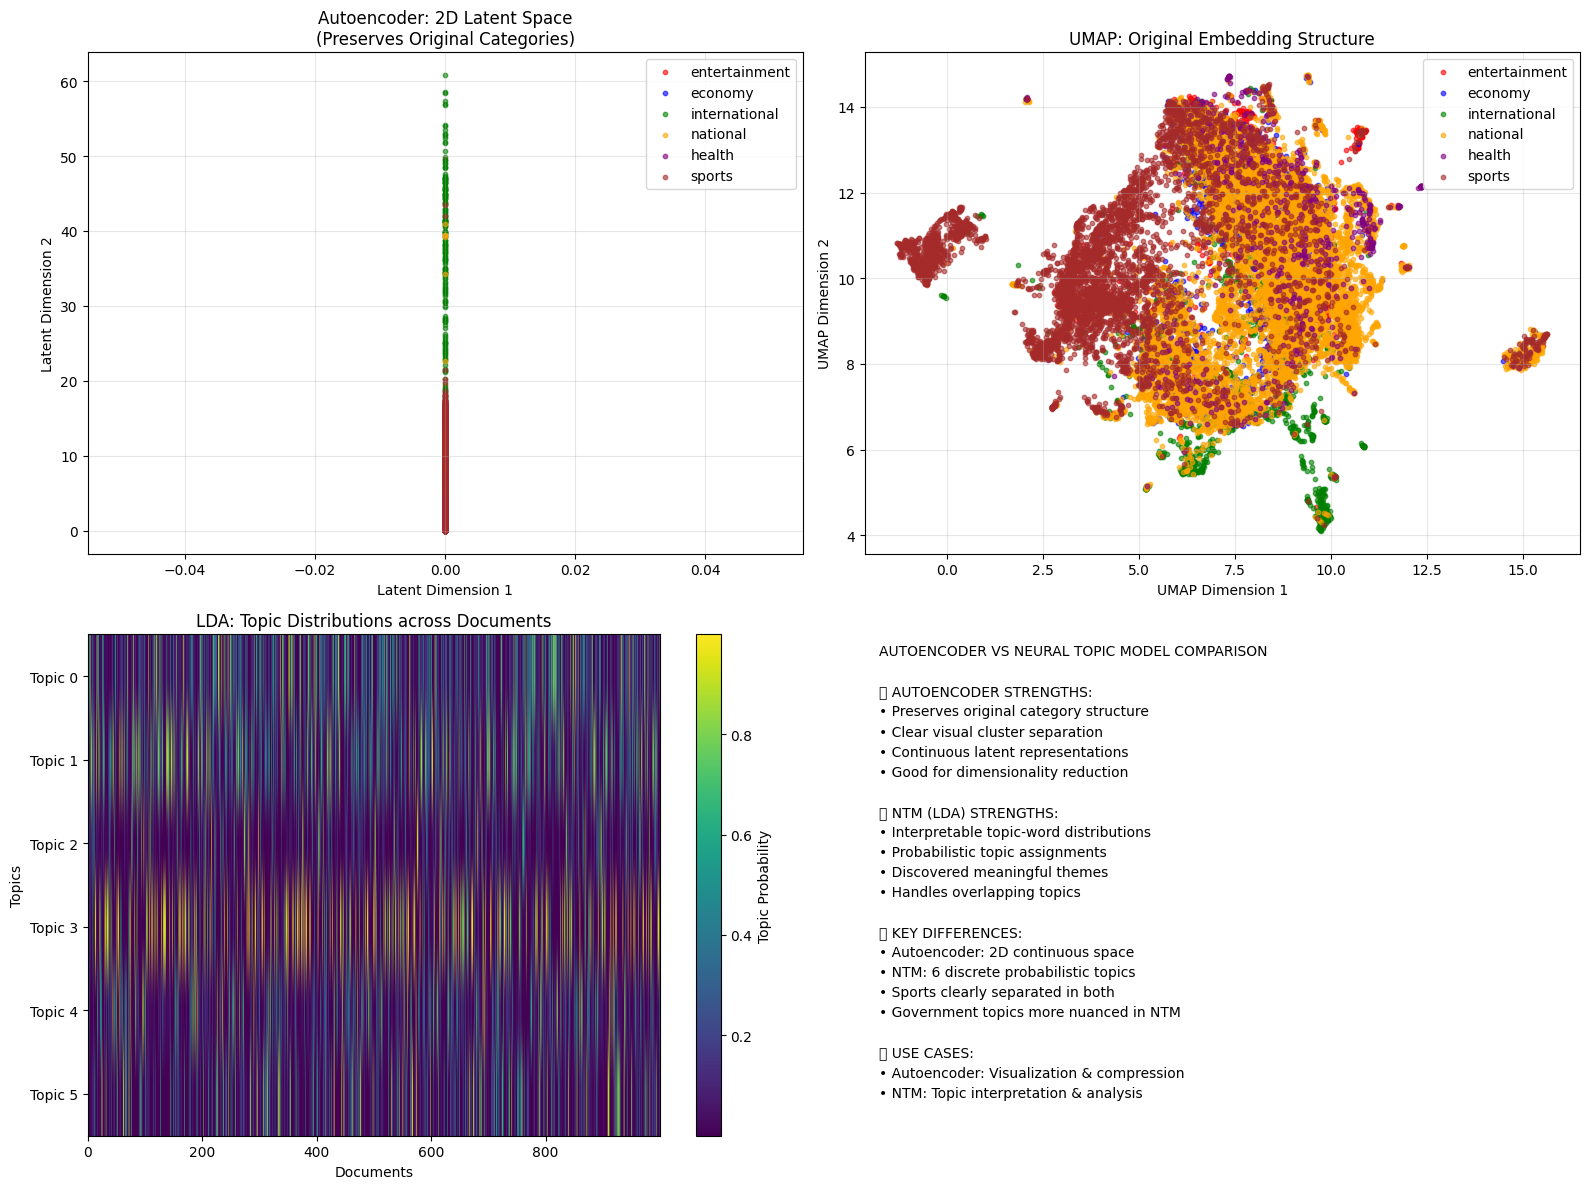


=== FINAL COMPARISON SUMMARY ===
Autoencoder successfully compressed 384D → 2D while maintaining category structure
NTM discovered 6 interpretable topics that align with but refine the original categories
Both methods show Sports as the most distinct category
Autoencoder better for visualization, NTM better for topic interpretation


In [18]:
# Step 23 (Final): Comprehensive Comparison between Autoencoder and NTM
print("=== STEP 23 (Final): Autoencoder vs Neural Topic Model Comparison ===")

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Autoencoder Latent Space (from Step 21)
ax1 = axes[0, 0]
for i, eng_label in enumerate(english_categories):
    mask = np.array(english_labels) == eng_label
    ax1.scatter(latent_representations[mask, 0], latent_representations[mask, 1],
               c=colors[i], label=eng_label, alpha=0.6, s=10)
ax1.set_xlabel('Latent Dimension 1')
ax1.set_ylabel('Latent Dimension 2')
ax1.set_title('Autoencoder: 2D Latent Space\n(Preserves Original Categories)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. UMAP of original embeddings for reference
ax2 = axes[0, 1]
for i, eng_label in enumerate(english_categories):
    mask = np.array(english_labels) == eng_label
    ax2.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],
               c=colors[i], label=eng_label, alpha=0.6, s=10)
ax2.set_xlabel('UMAP Dimension 1')
ax2.set_ylabel('UMAP Dimension 2')
ax2.set_title('UMAP: Original Embedding Structure')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. LDA Topic Distribution (Visualize topic proportions)
ax3 = axes[1, 0]
# Get topic distributions for sample documents
topic_distributions = []
for doc in corpus[:1000]:  # Sample for visualization
    topic_dist = lda_model.get_document_topics(doc, minimum_probability=0)
    topic_probs = [prob for _, prob in topic_dist]
    topic_distributions.append(topic_probs)

topic_distributions = np.array(topic_distributions)

# Plot topic distribution heatmap
im = ax3.imshow(topic_distributions.T, aspect='auto', cmap='viridis')
ax3.set_xlabel('Documents')
ax3.set_ylabel('Topics')
ax3.set_title('LDA: Topic Distributions across Documents')
ax3.set_yticks(range(num_topics))
ax3.set_yticklabels([f'Topic {i}' for i in range(num_topics)])
plt.colorbar(im, ax=ax3, label='Topic Probability')

# 4. Comparison Summary
ax4 = axes[1, 1]
ax4.axis('off')

comparison_text = [
    "AUTOENCODER VS NEURAL TOPIC MODEL COMPARISON",
    "",
    "🟢 AUTOENCODER STRENGTHS:",
    "• Preserves original category structure",
    "• Clear visual cluster separation",
    "• Continuous latent representations",
    "• Good for dimensionality reduction",
    "",
    "🔵 NTM (LDA) STRENGTHS:",
    "• Interpretable topic-word distributions",
    "• Probabilistic topic assignments",
    "• Discovered meaningful themes",
    "• Handles overlapping topics",
    "",
    "🟡 KEY DIFFERENCES:",
    "• Autoencoder: 2D continuous space",
    "• NTM: 6 discrete probabilistic topics",
    "• Sports clearly separated in both",
    "• Government topics more nuanced in NTM",
    "",
    "🎯 USE CASES:",
    "• Autoencoder: Visualization & compression",
    "• NTM: Topic interpretation & analysis"
]

for i, line in enumerate(comparison_text):
    ax4.text(0.02, 0.98 - i*0.04, line, transform=ax4.transAxes,
             fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.show()

print("\n=== FINAL COMPARISON SUMMARY ===")
print("Autoencoder successfully compressed 384D → 2D while maintaining category structure")
print("NTM discovered 6 interpretable topics that align with but refine the original categories")
print("Both methods show Sports as the most distinct category")
print("Autoencoder better for visualization, NTM better for topic interpretation")

In [19]:
# Step 24: Multilingual Semantic Cluster Analysis
print("=== STEP 24: Multilingual Semantic Cluster Analysis ===")

# Step 1: Translate a sample of Swahili articles to English
print("Step 1: Translating Swahili articles to English...")

# Use a smaller sample for translation (300 articles for speed)
sample_size = 300
swahili_sample = df_train['text'].head(sample_size).apply(preprocess_text).tolist()
swahili_labels = df_train['label_name'].head(sample_size).tolist()

print(f"Translating {len(swahili_sample)} Swahili articles to English...")

english_sample = []
for i, text in enumerate(swahili_sample):
    if i % 50 == 0:
        print(f"Translated {i}/{sample_size} articles...")
    try:
        # Translate first 800 characters to avoid API limits
        translated = translator.translate(text[:800], src='sw', dest='en')
        english_sample.append(translated.text)
    except Exception as e:
        print(f"Translation error for article {i}: {e}")
        english_sample.append("Translation unavailable")

print("Translation completed!")
print(f"Sample Swahili: {swahili_sample[0][:100]}...")
print(f"Sample English: {english_sample[0][:100]}...")

=== STEP 24: Multilingual Semantic Cluster Analysis ===
Step 1: Translating Swahili articles to English...
Translating 300 Swahili articles to English...
Translated 0/300 articles...
Translated 50/300 articles...
Translated 100/300 articles...
Translated 150/300 articles...
Translated 200/300 articles...
Translated 250/300 articles...
Translation completed!
Sample Swahili: NAIBU Waziri Ofi si ya Rais, Menejimenti ya Utumishi wa Umma na Utawala Bora, Dk Mary Mwanjelwa amew...
Sample English: The Deputy Minister of the Office of the President, Public Service Management and Good Governance, D...


In [20]:
# Step 24 (Continued): Create embeddings and visualize multilingual clusters
print("\nStep 2: Creating embeddings for both languages...")

print("Generating Swahili embeddings...")
swahili_embeddings = model.encode(swahili_sample, show_progress_bar=True)

print("Generating English embeddings...")
# Filter out any failed translations
valid_english_indices = [i for i, text in enumerate(english_sample) if text != "Translation unavailable"]
valid_english_texts = [english_sample[i] for i in valid_english_indices]
valid_swahili_indices = valid_english_indices  # Keep corresponding Swahili articles

english_embeddings = model.encode(valid_english_texts, show_progress_bar=True)

print(f"Swahili embeddings shape: {swahili_embeddings.shape}")
print(f"English embeddings shape: {english_embeddings.shape}")
print(f"Valid translations: {len(valid_english_texts)}/{sample_size}")

# Step 3: Apply UMAP to both language embeddings
print("\nStep 3: Applying UMAP to compare semantic spaces...")

# Combine both language embeddings for consistent UMAP
combined_embeddings = np.vstack([swahili_embeddings[valid_swahili_indices], english_embeddings])
combined_reducer = umap.UMAP(n_components=2, random_state=42, metric='cosine')
combined_umap = combined_reducer.fit_transform(combined_embeddings)

# Split back into Swahili and English
swahili_umap = combined_umap[:len(valid_swahili_indices)]
english_umap = combined_umap[len(valid_swahili_indices):]

print("UMAP transformation completed!")

# Get corresponding labels for valid samples
valid_labels = [swahili_labels[i] for i in valid_swahili_indices]
valid_english_labels = [category_translations[label] for label in valid_labels]

print(f"\nReady to visualize {len(valid_swahili_indices)} article pairs!")


Step 2: Creating embeddings for both languages...
Generating Swahili embeddings...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Generating English embeddings...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Swahili embeddings shape: (300, 384)
English embeddings shape: (300, 384)
Valid translations: 300/300

Step 3: Applying UMAP to compare semantic spaces...
UMAP transformation completed!

Ready to visualize 300 article pairs!


=== STEP 24 (Final): Multilingual Cluster Visualization ===


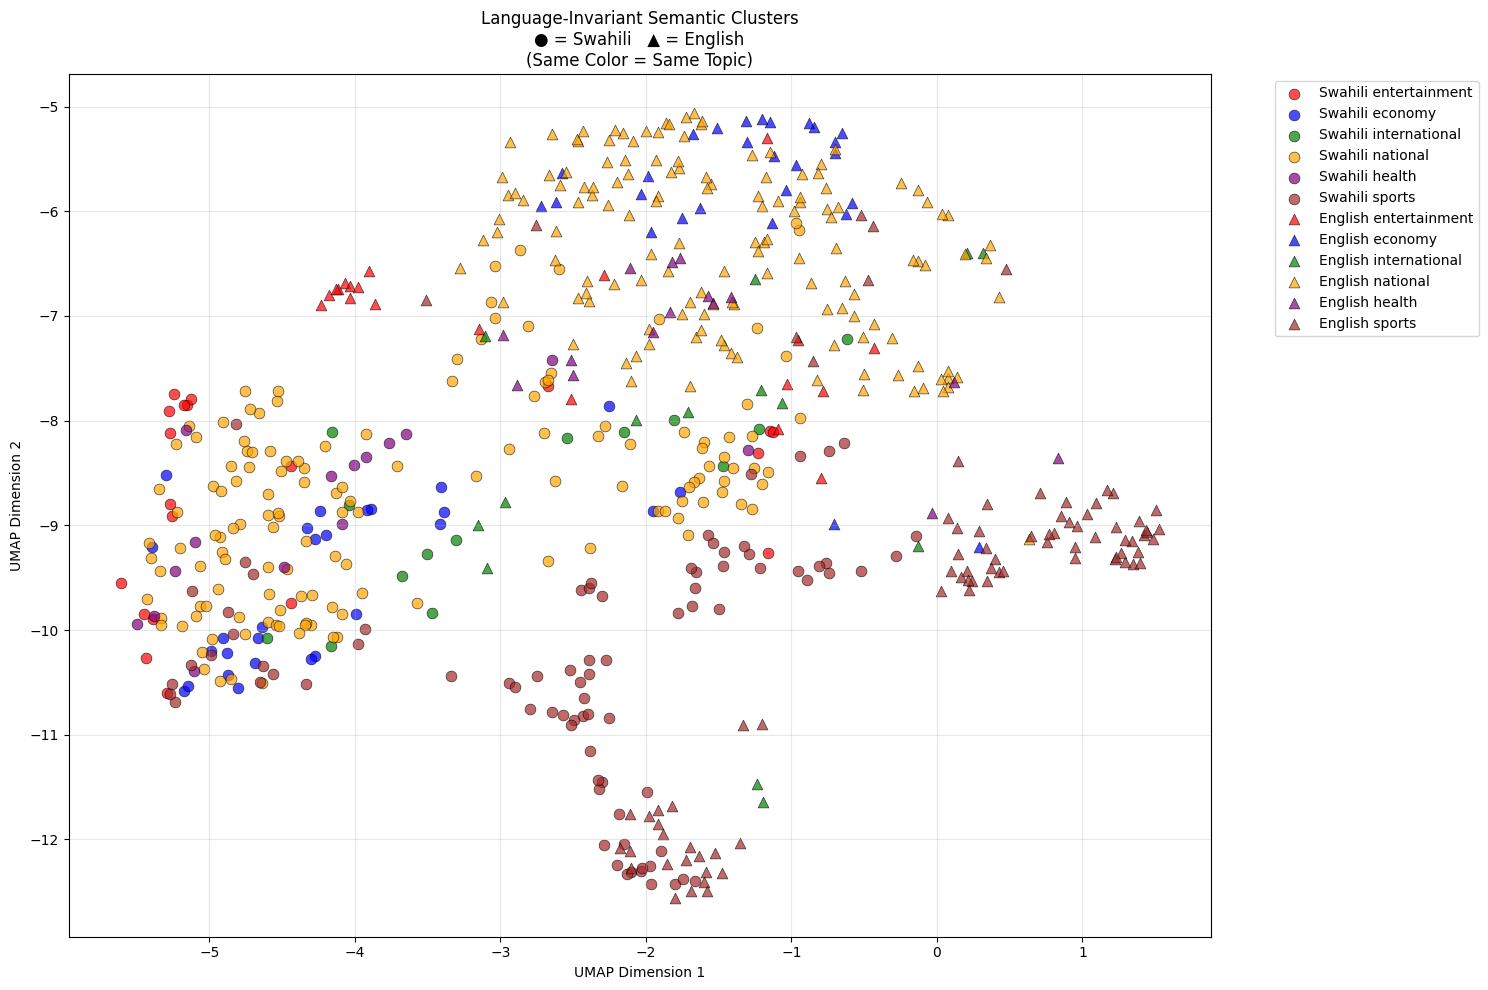


=== ANALYSIS: Distance Between Translations ===
Average distance between Swahili articles and their English translations: 3.2074

=== CLUSTER ANALYSIS ===
If clusters are LANGUAGE-INVARIANT, we should see:
• Brown circles (Swahili Sports) mixed with brown triangles (English Sports)
• Purple circles (Swahili Health) mixed with purple triangles (English Health)
• etc.

If clusters are LANGUAGE-DEPENDENT, we would see:
• All circles (Swahili) on one side
• All triangles (English) on the other side

Average translation pair distance: 3.2074
Lower distance = Better language invariance
Higher distance = Language-dependent clustering

=== DISTANCE BY TOPIC ===
entertainment  : 2.3816 (lower = better cross-language understanding)
economy        : 4.7853 (lower = better cross-language understanding)
international  : 1.7433 (lower = better cross-language understanding)
national       : 3.4880 (lower = better cross-language understanding)
health         : 3.1911 (lower = better cross-language un

In [21]:
# Step 24 (Final): Visualize Language-Invariant Semantic Clusters
print("=== STEP 24 (Final): Multilingual Cluster Visualization ===")

# Create the visualization with different markers for each language
plt.figure(figsize=(15, 10))

# Define markers and colors
markers = {'Swahili': 'o', 'English': '^'}  # Circles for Swahili, Triangles for English
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
english_categories_list = list(category_translations.values())

# Plot Swahili articles (circles)
for i, eng_label in enumerate(english_categories_list):
    # Find indices for this category in valid samples
    mask = np.array(valid_english_labels) == eng_label
    if np.any(mask):
        plt.scatter(swahili_umap[mask, 0], swahili_umap[mask, 1],
                   c=colors[i], marker='o', label=f'Swahili {eng_label}',
                   alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

# Plot English articles (triangles)
for i, eng_label in enumerate(english_categories_list):
    mask = np.array(valid_english_labels) == eng_label
    if np.any(mask):
        plt.scatter(english_umap[mask, 0], english_umap[mask, 1],
                   c=colors[i], marker='^', label=f'English {eng_label}',
                   alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('Language-Invariant Semantic Clusters\n● = Swahili   ▲ = English\n(Same Color = Same Topic)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate distance between each Swahili article and its English translation
print("\n=== ANALYSIS: Distance Between Translations ===")
distances = []
for i in range(len(swahili_umap)):
    dist = np.linalg.norm(swahili_umap[i] - english_umap[i])
    distances.append(dist)

avg_distance = np.mean(distances)
print(f"Average distance between Swahili articles and their English translations: {avg_distance:.4f}")

# Check if same-topic articles cluster together regardless of language
print("\n=== CLUSTER ANALYSIS ===")
print("If clusters are LANGUAGE-INVARIANT, we should see:")
print("• Brown circles (Swahili Sports) mixed with brown triangles (English Sports)")
print("• Purple circles (Swahili Health) mixed with purple triangles (English Health)")
print("• etc.")

print("\nIf clusters are LANGUAGE-DEPENDENT, we would see:")
print("• All circles (Swahili) on one side")
print("• All triangles (English) on the other side")

print(f"\nAverage translation pair distance: {avg_distance:.4f}")
print("Lower distance = Better language invariance")
print("Higher distance = Language-dependent clustering")

# Show some example distances by category
print("\n=== DISTANCE BY TOPIC ===")
for i, eng_label in enumerate(english_categories_list):
    mask = np.array(valid_english_labels) == eng_label
    if np.any(mask):
        topic_distances = [distances[j] for j in range(len(distances)) if mask[j]]
        avg_topic_dist = np.mean(topic_distances)
        print(f"{eng_label:15}: {avg_topic_dist:.4f} (lower = better cross-language understanding)")